In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import os
import pandas as pd
import matplotlib.pyplot as plt


### Clone the github directory files

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + files for files in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Reading and preprocessing the datas

In [ ]:
# opening the one of files
with open(filenames[0]) as f:
  lines = f.readlines()

In [ ]:
lines[:13]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
 'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
 'RESULTS\tSixty-five patients were randomized .

The new abstract starstwith '###' signs and ends with '\n'
between them, are the sentences of that abstract

In [5]:
# defining the function for data creating
def preprocess_data(path):
  """
  Function makes pandas DataFrame from given file path
  Each row is taken as separate sentence and splited with '\t' 
  From that split got the target and text of that line
  additional abstract number and line of each sentence of that abstract is given

  Args:
      path(str): path to file
  Returns:
      pandas.DataFrame
  """
  with open(path) as f:
    txt = f.readlines()
    f.close()
  abstract_number = 0
  lines_of_abstract = 0
  abstracts = []
  rows = []
  text = []
  label = []
  for line in txt:
    if line.startswith("###"):
      abstract_number += 1
    elif line.isspace():
      lines_of_abstract = 0
    else:
      lines_of_abstract += 1
      sentence = line.split("\t")
      label.append(sentence[0])
      text.append(sentence[1])
      abstracts.append(abstract_number)
      rows.append(lines_of_abstract)
  data = {"abstract_number": abstracts,
          "line": rows,
          "text": text,
          "target": label}
  return pd.DataFrame(data)

In [6]:
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [7]:
# creating datasets
train_df = preprocess_data(filenames[0])
valid_df = preprocess_data(filenames[1])
test_df = preprocess_data(filenames[2])
train_df.shape, valid_df.shape, test_df.shape

((180040, 4), (30212, 4), (30135, 4))

In [ ]:
train_df.head(13)

,abstract_number,line,text,target
0,1,1,To investigate the efficacy of @ weeks of dail...,OBJECTIVE
1,1,2,A total of @ patients with primary knee OA wer...,METHODS
2,1,3,Outcome measures included pain reduction and i...,METHODS
3,1,4,Pain was assessed using the visual analog pain...,METHODS
4,1,5,Secondary outcome measures included the Wester...,METHODS
5,1,6,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",METHODS
6,1,7,There was a clinically relevant reduction in t...,RESULTS
7,1,8,The mean difference between treatment arms ( @...,RESULTS
8,1,9,"Further , there was a clinically relevant redu...",RESULTS
9,1,10,These differences remained significant at @ we...,RESULTS


#### Analysis of targets

In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

Dataset is a little unbalanced, it can be seen 'OBJECTIVE' variabele is slightly less than other ones

In [8]:
# making one hot encoded the target variable
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
train_df['target'] = oe.fit_transform(train_df.target.values.reshape(-1, 1))
valid_df['target'] = oe.transform(valid_df.target.values.reshape(-1, 1))
test_df['target'] = oe.transform(test_df.target.values.reshape(-1, 1))

In [9]:
train_target_one_hot = tf.keras.utils.to_categorical(train_df.target.values, 5)
valid_target_one_hot = tf.keras.utils.to_categorical(valid_df.target.values, 5)
test_target_one_hot = tf.keras.utils.to_categorical(test_df.target.values, 5)

In [ ]:
train_df.target.values[0], train_target_one_hot[0]

(3.0, array([0., 0., 0., 1., 0.], dtype=float32))

In [10]:
# creating the function which
from sklearn.metrics import accuracy_score, precision_score, f1_score
def model_results(y_true, y_pred):
  print(f"The Accuracy is:  {round(accuracy_score(y_true, y_pred), 4)}")
  print()
  print(f"The Precsion is:  {round(precision_score(y_true, y_pred, average='weighted'), 4)}")
  print()
  print(f"The F1 is:  {round(f1_score(y_true, y_pred, average='weighted'), 4)}")
  return None

## Baseline model

Naive Bayes model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

vec = TfidfVectorizer()
cls = MultinomialNB()

model_0 = Pipeline([
                    ("tf_idf", vec),
                    ("cls", cls)
])

model_0.fit(train_df.text.values,
            train_df.target.values)

y_pred_model_0 = model_0.predict(
                                valid_df.text.values,
                                 )

model_results(valid_df.target.values, y_pred_model_0)

The Accuracy is:  0.7218

The Precsion is:  0.7186

The F1 is:  0.6989


#### Checking sentences lenghts for vectorizing

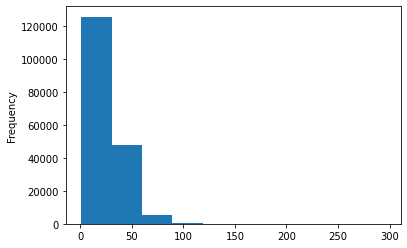

In [ ]:
lens = [len(train_df.text.values[i].split(" ")) for i in range(train_df.shape[0])]
pd.Series(lens).plot(kind='hist')

In [ ]:
lens = np.array(lens)
np.percentile(lens, 95)

55.0

95 percentile of sentences lenghts is 55, therefore 55 will be taken as tokenizer output layer

## CNN1D model

* Tokenizing layer
* Embedding layer
* Conv1NN layer
* Global Average layer
* Softmax layer

Text vectorizer(tokenizer) layer

In [11]:
text_vec_small = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = 68000, # number is taken from original paper
    output_sequence_length = 55 # 95 percentile of sentences lenghts
    # other arguments will remain defaults
)

# adapting in the training set

text_vec_small.adapt(train_df.text.values)

In [ ]:
# Checking some results
print("the sentence: \n")
print(f"{train_df.text.values[0]}")
print("the tokenized sentence")
print(f"{text_vec_small([train_df.text.values[0]])}")

the sentence: 

To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .

the tokenized sentence
[[   6  331    2   79    4   53    4  161 1127  217 2535    5  557   65
  1584    3  670 5559  636    5    2  654 1137    3  180    2   70  495
    36  781   15   53    5  350  266    7  362    6  289  517 1430 1743
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [12]:
word_vocab = text_vec_small.get_vocabulary()
print(len(word_vocab))

64841


Embedding layer

In [13]:
emb_layer = tf.keras.layers.Embedding(
    input_dim=len(word_vocab),  # input has to be vocab length
    output_dim=128,   # custom number preferable little number for less time consuption
    mask_zero = True,
    name="embed_layer"
)

In [ ]:
# Checking the results
print("the sentence: \n")
print(f"{train_df.text.values[0]}")
print("the tokenized sentence: \n")
print(f"{text_vec_small([train_df.text.values[0]])}")
print("Embedded text: \n")
emb_layer(text_vec_small([train_df.text.values[0]]))

the sentence: 

To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .

the tokenized sentence: 

[[   6  331    2   79    4   53    4  161 1127  217 2535    5  557   65
  1584    3  670 5559  636    5    2  654 1137    3  180    2   70  495
    36  781   15   53    5  350  266    7  362    6  289  517 1430 1743
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
Embedded text: 



<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-0.00991433, -0.03833934, -0.04749556, ..., -0.02892951,
          0.01073226, -0.04692955],
        [ 0.04546713,  0.01268805, -0.02272488, ..., -0.02088289,
         -0.0263833 ,  0.04676808],
        [-0.04013566,  0.02003766, -0.00646236, ..., -0.0020439 ,
         -0.04860628,  0.0171285 ],
        ...,
        [ 0.04604976, -0.03663976,  0.02161053, ...,  0.04986833,
          0.02679907,  0.03289596],
        [ 0.04604976, -0.03663976,  0.02161053, ...,  0.04986833,
          0.02679907,  0.03289596],
        [ 0.04604976, -0.03663976,  0.02161053, ...,  0.04986833,
          0.02679907,  0.03289596]]], dtype=float32)>

CNN model

In [14]:
NUM_CLASSES = train_df.target.nunique()
BATCH_SIZE = 32
EPOCHS = 5


inputs = tf.keras.Input(shape=(1, ), dtype=tf.string, batch_size=BATCH_SIZE, name="input_layer")
x = text_vec_small(inputs)
x = emb_layer(x)
x = tf.keras.layers.Conv1D(128, kernel_size=(3, ), 
                           strides=1, padding='same',
                           activation='relu', name='conv1d_layer')(x)
x = tf.keras.layers.GlobalAveragePooling1D(name='global_aver_layer')(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs, name='model_1_cnn1d')

model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

model_1.summary()

Model: "model_1_cnn1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(32, 1)]                 0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
embed_layer (Embedding)      (None, 55, 128)           8299648   
_________________________________________________________________
conv1d_layer (Conv1D)        (None, 55, 128)           49280     
_________________________________________________________________
global_aver_layer (GlobalAve (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 645       
Total params: 8,349,573
Trainable params: 8,349,573
Non-trainable params: 0
___________________________________________

Before training the dataset, additional tf.dataset will be created for fastening the training process

### Creating tf dataset

In [15]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_df.text.values, train_target_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_df.text.values, valid_target_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df.text.values, test_target_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float32)>

In [16]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float32)>

Fitting in model_1

In [ ]:
model_1.hist = model_1.fit(train_dataset,
                           epochs=EPOCHS,
                           verbose=1,
                           steps_per_epoch=int(0.1 * len(train_dataset)), # fitting only 10% percent of train data for less time consume and to do more experiments
                           validation_data=valid_dataset,
                           validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 37s 14ms/step - loss: 0.9132 - accuracy: 0.6370 - val_loss: 0.6798 - val_accuracy: 0.7417
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.6555 - accuracy: 0.7565 - val_loss: 0.6291 - val_accuracy: 0.7726
Epoch 3/5
562/562 [==============================] - 8s 14ms/step - loss: 0.6177 - accuracy: 0.7744 - val_loss: 0.5966 - val_accuracy: 0.7842
Epoch 4/5
562/562 [==============================] - 8s 14ms/step - loss: 0.5907 - accuracy: 0.7892 - val_loss: 0.5774 - val_accuracy: 0.7886
Epoch 5/5
562/562 [==============================] - 8s 14ms/step - loss: 0.5914 - accuracy: 0.7913 - val_loss: 0.5627 - val_accuracy: 0.7959


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.5627 - accuracy: 0.7988


[0.5627071261405945, 0.7987554669380188]

In [ ]:
y_pred_model_1 = model_1.predict(valid_df.text.values)

In [ ]:
model_results(y_true=valid_target_one_hot.argmax(axis=1),
              y_pred=y_pred_model_1.argmax(axis=1))

The Accuracy is:  0.7988

The Precsion is:  0.7983

The F1 is:  0.7957


The model_1 had better results in validation set than baseline model

## Model_2 Feature extractor
* USE extractor
* Global average pooling
* softmax

In [17]:
# USE layer
embed_layer_keras = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                   trainable=False,
                                   input_shape=[],  # any shape of string can be given to model
                                   
                                   dtype=tf.string,
                                   name='use_embedding_layer')

In [ ]:
inputs = tf.keras.Input(shape=[], # any shape text 
                        dtype=tf.string,
                        batch_size=BATCH_SIZE,
                        name="input_layer")
x = embed_layer_keras(inputs)
x = tf.keras.layers.BatchNormalization(name='batch_norm_layer')(x)
x = tf.keras.layers.Dense(128, activation='relu', name='dense_layer')(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs, name='model_2_use_feat_extr')

model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

model_2.summary()

Model: "model_2_use_feat_extr"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(32,)]                   0         
_________________________________________________________________
use_embedding_layer (KerasLa (None, 512)               256797824 
_________________________________________________________________
batch_norm_layer (BatchNorma (None, 512)               2048      
_________________________________________________________________
dense_layer (Dense)          (None, 128)               65664     
_________________________________________________________________
output_layer (Dense)         (None, 5)                 645       
Total params: 256,866,181
Trainable params: 67,333
Non-trainable params: 256,798,848
_________________________________________________________________


In [20]:
TRAIN_STEPS = int(0.25 * len(train_dataset))
VALID_STEPS = int(0.1 * len(valid_dataset))
TRAIN_STEPS, VALID_STEPS

(1406, 94)

In [ ]:
model_2_hist = model_2.fit(train_dataset,
                           epochs=EPOCHS,
                           verbose=1,
                           steps_per_epoch=TRAIN_STEPS,
                           validation_data=valid_dataset,
                           validation_steps=VALID_STEPS)

Epoch 1/5
562/562 [==============================] - 14s 20ms/step - loss: 0.8630 - accuracy: 0.6656 - val_loss: 0.7706 - val_accuracy: 0.7108
Epoch 2/5
562/562 [==============================] - 11s 19ms/step - loss: 0.7400 - accuracy: 0.7179 - val_loss: 0.7009 - val_accuracy: 0.7254
Epoch 3/5
562/562 [==============================] - 11s 19ms/step - loss: 0.7129 - accuracy: 0.7236 - val_loss: 0.6803 - val_accuracy: 0.7330
Epoch 4/5
562/562 [==============================] - 11s 19ms/step - loss: 0.6900 - accuracy: 0.7375 - val_loss: 0.6589 - val_accuracy: 0.7553
Epoch 5/5
562/562 [==============================] - 11s 19ms/step - loss: 0.6935 - accuracy: 0.7335 - val_loss: 0.6530 - val_accuracy: 0.7477


In [ ]:
model_2.evaluate(valid_dataset)
model_2.evaluate(test_dataset)

942/942 [==============================] - 15s 16ms/step - loss: 0.6842 - accuracy: 0.7397


[0.6841824054718018, 0.739737868309021]

In [ ]:
y_pred_model_2 = model_2.predict(valid_df.text.values)
model_results(y_true=valid_target_one_hot.argmax(axis=1),
              y_pred=y_pred_model_2.argmax(axis=1))

The Accuracy is:  0.7477

The Precsion is:  0.7435

The F1 is:  0.7417


In [ ]:
!nvidia-smi

Mon Sep 20 13:28:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    60W / 149W |   2171MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

CNN model performed better than USE model
next model will be 2 Conv1D layers

## Model_3

In [ ]:
inputs = tf.keras.Input(shape=(1, ), dtype=tf.string, batch_size=BATCH_SIZE, name="input_layer")
x = text_vec_small(inputs)
x = emb_layer(x)
x = tf.keras.layers.Conv1D(128, kernel_size=(3, ), 
                           strides=1, padding='same',
                           activation='relu', name='conv1d_layer_1')(x)

x = tf.keras.layers.Conv1D(256, kernel_size=(3, ), 
                           strides=1, padding='same',
                           activation='relu', name='conv1d_layer_2')(x)
x = tf.keras.layers.GlobalAveragePooling1D(name='global_aver_layer')(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

model_3 = tf.keras.Model(inputs, outputs, name='model_3_cnn')

model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

model_3.summary()

Model: "model_3_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(32, 1)]                 0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
embed_layer (Embedding)      (None, 55, 128)           8299648   
_________________________________________________________________
conv1d_layer_1 (Conv1D)      (None, 55, 128)           49280     
_________________________________________________________________
conv1d_layer_2 (Conv1D)      (None, 55, 256)           98560     
_________________________________________________________________
global_aver_layer (GlobalAve (None, 256)               0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 

In [ ]:
model_3_hist = model_3.fit(train_dataset,
                           epochs=EPOCHS+5,
                           verbose=1,
                           steps_per_epoch=TRAIN_STEPS,
                           validation_data=valid_dataset,
                           validation_steps=VALID_STEPS)

Epoch 1/10
562/562 [==============================] - 10s 16ms/step - loss: 0.8689 - accuracy: 0.6852 - val_loss: 0.6339 - val_accuracy: 0.7563
Epoch 2/10
562/562 [==============================] - 9s 15ms/step - loss: 0.5220 - accuracy: 0.8094 - val_loss: 0.6005 - val_accuracy: 0.7799
Epoch 3/10
562/562 [==============================] - 9s 15ms/step - loss: 0.4824 - accuracy: 0.8265 - val_loss: 0.5935 - val_accuracy: 0.7876
Epoch 4/10
562/562 [==============================] - 9s 15ms/step - loss: 0.4501 - accuracy: 0.8430 - val_loss: 0.5854 - val_accuracy: 0.7899
Epoch 5/10
562/562 [==============================] - 9s 15ms/step - loss: 0.4378 - accuracy: 0.8526 - val_loss: 0.5757 - val_accuracy: 0.7995
Epoch 6/10
562/562 [==============================] - 9s 15ms/step - loss: 0.5955 - accuracy: 0.7890 - val_loss: 0.5673 - val_accuracy: 0.7979
Epoch 7/10
562/562 [==============================] - 8s 15ms/step - loss: 0.5742 - accuracy: 0.7936 - val_loss: 0.5604 - val_accuracy: 0.798

In [ ]:
y_pred_model_3 = model_3.predict(valid_df.text.values)
model_results(y_true=valid_target_one_hot.argmax(axis=1),
              y_pred=y_pred_model_3.argmax(axis=1))

The Accuracy is:  0.8046

The Precsion is:  0.8004

The F1 is:  0.8015


In [21]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

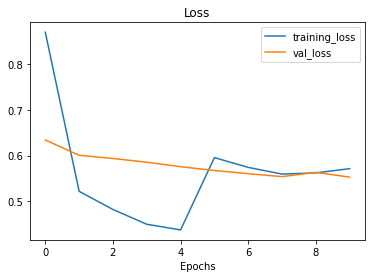

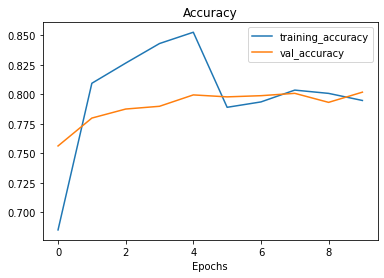

In [ ]:
plot_loss_curves(model_3_hist)

## Model_4

In [ ]:
inputs = tf.keras.Input(shape=(1, ), dtype=tf.string, batch_size=BATCH_SIZE, name="input_layer")
x = text_vec_small(inputs)
x = emb_layer(x)
x = tf.keras.layers.Conv1D(128, kernel_size=(3, ), 
                           strides=1, padding='valid',
                           activation=None, name='conv1d_layer_1')(x)
x = tf.keras.layers.BatchNormalization(name='batch_norm_1')(x)
x = tf.keras.activations.relu(x)

x = tf.keras.layers.Conv1D(256, kernel_size=(3, ), 
                           strides=1, padding='valid',
                           activation=None, name='conv1d_layer_2')(x)
x = tf.keras.layers.BatchNormalization(name='batch_norm_2')(x)
x = tf.keras.activations.relu(x)

x = tf.keras.layers.Conv1D(512, kernel_size=(3, ), 
                           strides=1, padding='valid',
                           activation=None, name='conv1d_layer_3')(x)
x = tf.keras.layers.BatchNormalization(name='batch_norm_3')(x)

x = tf.keras.layers.GlobalAveragePooling1D(name='global_ave_layer')(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

model_4 = tf.keras.Model(inputs, outputs, name='model_4_cnn')

model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

model_4.summary()

Model: "model_4_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(32, 1)]                 0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
embed_layer (Embedding)      (None, 55, 128)           8299648   
_________________________________________________________________
conv1d_layer_1 (Conv1D)      (None, 53, 128)           49280     
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 53, 128)           512       
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 53, 128)           0         
_________________________________________________________________
conv1d_layer_2 (Conv1D)      (None, 51, 256)           

In [ ]:
model_4_hist = model_4.fit(train_dataset,
                           epochs=EPOCHS+5,
                           verbose=1,
                           steps_per_epoch=TRAIN_STEPS,
                           validation_data=valid_dataset,
                           validation_steps=VALID_STEPS)

Epoch 1/10
562/562 [==============================] - 14s 23ms/step - loss: 0.6282 - accuracy: 0.7784 - val_loss: 0.6496 - val_accuracy: 0.7689
Epoch 2/10
562/562 [==============================] - 12s 22ms/step - loss: 0.4994 - accuracy: 0.8258 - val_loss: 0.6183 - val_accuracy: 0.7806
Epoch 3/10
562/562 [==============================] - 12s 22ms/step - loss: 0.4499 - accuracy: 0.8422 - val_loss: 0.6024 - val_accuracy: 0.7899
Epoch 4/10
562/562 [==============================] - 12s 22ms/step - loss: 0.4259 - accuracy: 0.8546 - val_loss: 0.6886 - val_accuracy: 0.7753
Epoch 5/10
562/562 [==============================] - 12s 22ms/step - loss: 0.4102 - accuracy: 0.8642 - val_loss: 0.5724 - val_accuracy: 0.8015
Epoch 6/10
562/562 [==============================] - 12s 22ms/step - loss: 0.5621 - accuracy: 0.7953 - val_loss: 0.5729 - val_accuracy: 0.7932
Epoch 7/10
562/562 [==============================] - 13s 22ms/step - loss: 0.5365 - accuracy: 0.8068 - val_loss: 0.5469 - val_accuracy:

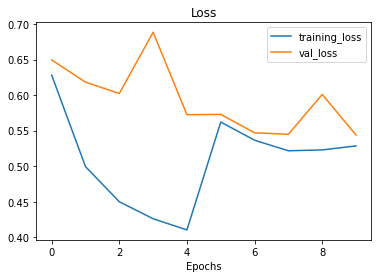

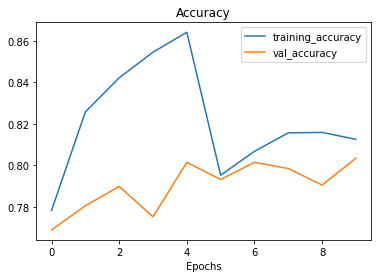

In [ ]:
plot_loss_curves(model_4_hist)

In [ ]:
y_pred_model_4 = model_4.predict(valid_df.text.values)
model_results(y_true=valid_target_one_hot.argmax(axis=1),
              y_pred=y_pred_model_4.argmax(axis=1))

The Accuracy is:  0.8063

The Precsion is:  0.8092

The F1 is:  0.8051


## Model_5
* Tokenizer layer (characters)
* Embedding layer
* CNN1D layer
* Global Average layer
* Softmax

### Create character level tokenizer

In [22]:
# create a function which will make character level sequence as strings
def character_making(sentences):
  return [" ".join(list(sentence)) for sentence in sentences]

train_chars = character_making(train_df.text.values)
valid_chars = character_making(valid_df.text.values)
test_chars = character_making(test_df.text.values)

train_chars[0]

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   . \n'

In [23]:
# 95 percentile of lenghts
lens_char = [len(train_chars[i]) for i in range(len(train_chars))]
np.percentile(np.array(lens_char), 90), np.mean(lens_char)

(495.0, 299.7325149966674)

In [24]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [25]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                                                              output_sequence_length=300,
                                                                              standardize="lower_and_strip_punctuation",
                                                                              name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [26]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [27]:
import random
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
S y s t o l i c   b l o o d   p r e s s u r e   v a r i a b i l i t y   s e e m s   t o   p r e d i c t   a   p o o r   o u t c o m e   i n   p a t i e n t s   w i t h   a c u t e   i n t r a c e r e b r a l   h a e m o r r h a g e   . 


Length of chars: 102

Vectorized chars:
[[ 9 19  9  3  7 12  4 11 22 12  7  7 10 14  8  2  9  9 16  8  2 21  5  8
   4  5 22  4 12  4  3 19  9  2  2 15  9  3  7 14  8  2 10  4 11  3  5 14
   7  7  8  7 16  3 11  7 15  2  4  6 14  5  3  4  2  6  3  9 20  4  3 13
   5 11 16  3  2  4  6  3  8  5 11  2  8  2 22  8  5 12 13  5  2 15  7  8
   8 13  5 18  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  

In [28]:
embed_char_layer = tf.keras.layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of characters in vocab
                                             output_dim=25, # from paper
                                             mask_zero=True,
                                             name='emdedding_char_layer')

In [29]:
# Test out character vectorizer and embedding
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")
print("Embedded matrix: \n")
print(embed_char_layer(vectorized_chars))
print(f"Shape: {embed_char_layer(vectorized_chars).shape}")

Charified text:
C l i n i c a l   ,   q u a l i t y   o f   l i f e   a n d   h e a l t h   b e h a v i o u r a l   d a t a   w i l l   b e   c o l l e c t e d   a t   b a s e l i n e   ,   s i x   w e e k s   ,   t h r e e   a n d   s i x   m o n t h s   . 


Length of chars: 99

Vectorized chars:
[[11 12  4  6  4 11  5 12 26 16  5 12  4  3 19  7 17 12  4 17  2  5  6 10
  13  2  5 12  3 13 22  2 13  5 21  4  7 16  8  5 12 10  5  3  5 20  4 12
  12 22  2 11  7 12 12  2 11  3  2 10  5  3 22  5  9  2 12  4  6  2  9  4
  24 20  2  2 23  9  3 13  8  2  2  5  6 10  9  4 24 15  7  6  3 13  9  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0

In [ ]:
# model
inputs = tf.keras.Input(shape=[], dtype=tf.string, 
                        batch_size=32,
                        name='input_layer')
x = char_vectorizer(inputs)
x = embed_char_layer(x)
x = tf.keras.layers.Conv1D(128, kernel_size=(3, ),
                           strides=1, padding='same',
                           activation='relu', name='conv_layer')(x)
x = tf.keras.layers.GlobalAveragePooling1D(name='global_ave_layer')(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

model_5 = tf.keras.Model(inputs, outputs, name='model_5_char_emb')

model_5.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
model_5.summary()

Model: "model_5_char_emb"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(32,)]                   0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 300)               0         
_________________________________________________________________
emdedding_char_layer (Embedd (None, 300, 25)           1750      
_________________________________________________________________
conv_layer (Conv1D)          (None, 300, 128)          9728      
_________________________________________________________________
global_ave_layer (GlobalAver (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 645       
Total params: 12,123
Trainable params: 12,123
Non-trainable params: 0
______________________________________________

In [30]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_target_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((valid_chars, valid_target_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset


<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float32)>

In [ ]:
model_5_hist = model_5.fit(train_char_dataset,
                           epochs=10,
                           verbose=1,
                           steps_per_epoch=TRAIN_STEPS,
                           validation_data=valid_char_dataset,
                           validation_steps=VALID_STEPS)

Epoch 1/10
1124/1124 [==============================] - 11s 10ms/step - loss: 1.4128 - accuracy: 0.3871 - val_loss: 1.3355 - val_accuracy: 0.4368
Epoch 2/10
1124/1124 [==============================] - 10s 9ms/step - loss: 1.3177 - accuracy: 0.4524 - val_loss: 1.3039 - val_accuracy: 0.4601
Epoch 3/10
1124/1124 [==============================] - 10s 9ms/step - loss: 1.3016 - accuracy: 0.4550 - val_loss: 1.2935 - val_accuracy: 0.4644
Epoch 4/10
1124/1124 [==============================] - 11s 9ms/step - loss: 1.2904 - accuracy: 0.4624 - val_loss: 1.2764 - val_accuracy: 0.4747
Epoch 5/10
1124/1124 [==============================] - 10s 9ms/step - loss: 1.2796 - accuracy: 0.4684 - val_loss: 1.2601 - val_accuracy: 0.4771
Epoch 6/10
   7/1124 [..............................] - ETA: 13s - loss: 1.3152 - accuracy: 0.4100WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this

1124/1124 [==============================] - 1s 443us/step - loss: 1.3152 - accuracy: 0.4100 - val_loss: 1.2616 - val_accuracy: 0.4774


# Importing all PubMed Data train data

In [33]:
data_dir = "pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + files for files in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt']

In [34]:
# unzip the train data
import zipfile
zip = zipfile.ZipFile(filenames[0], 'r')
zip.extractall()
zip.close()

In [35]:
train_df = preprocess_data("train.txt")
print(train_df.shape)
train_df.head()

(2211861, 4)


,abstract_number,line,text,target
0,1,1,The emergence of HIV as a chronic condition me...,BACKGROUND
1,1,2,This paper describes the design and evaluation...,BACKGROUND
2,1,3,This study is designed as a randomised control...,METHODS
3,1,4,The intervention group will participate in the...,METHODS
4,1,5,The program is based on self-efficacy theory a...,METHODS


In [36]:
valid_df = preprocess_data(filenames[1])
test_df = preprocess_data(filenames[2])
valid_df.shape, test_df.shape

((28932, 4), (29493, 4))

In [ ]:
train_df.target.value_counts()

RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: target, dtype: int64

### Making the balancing data flow (this section can be ignored because of errors)
Because the target variable is unbalanced the new custom DataGenerator class will be created as a sequence there for given batch size approximately the equal quantity of each targets will be taken. In this specific case.
The batch_size = 64
where targets:
 * RESULTS = 14
 * METHODS = 14
 * CONCLUSIONS = 12
 * BACKGROUND = 12
 * OBJECTIVE = 12


In [ ]:
# # creating the class
# class BalancedDataGen(tf.keras.utils.Sequence):
#   def __init__(self, df, x_cols, y_cols, batch_size=64):
#     """
#     This class inherites the tensorflow's Sequence class.
#     Class is created for making target balanced data generator.

#     Args:
#       df: pandas.DataFrame
#       x_cols: list of features, in this case 'text' column must be there, if 
#               other column will be included in that case it will be one hot encoded
#       y_cols: target variable name
#       batch_size: DataGen's batch_size as a integer
#     """
#     self.df = df
#     self.x_cols = x_cols
#     self.y_cols = y_cols
#     self.batch_size = batch_size

#     self.uniques = list(self.df[y_cols].unique())
#     self.size = self.df.shape[0]
#     self.quantity = [14, 14, 12, 12, 12]

   

#     def __get_data(self, data):
#       """
#       Method will create dataset with the size of given batch_size.
#       This is the helper function from which will return the dataset
#       """
#       indexes = []
#       for i in range(len(self.uniques)):
#         index_tmp = data.loc[data[self.y_cols] == self.uniques[i]].index
#         indexes.append(list(np.random.choice(index_tmp, self.quantity[i])))
#       indexes = np.array(indexes)
#       indexes = np.reshape(indexes, newshape=(sum(self.quantity),))
#       return data.iloc[indexes, :].sample(frac=1.0)

        
#     def __getitem__(self, index):
#       batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
#       data = self.__get_data(bathces)
#       X = np.array(data[self.x_cols])
#       y = tf.keras.utils.to_categorical(data[self.y_cols].to_numpy(), len(self.uniques))
#       return X, tuple(y)
    
#     def __len__(self):
#       return self.size // self.batch_size

#      # on epoch end is required method(see tf documentation)
#     def on_epoch_end(self):
#       return self.df.sample(frac=1).reset_index(drop=True)
  

In [ ]:
# an example how code will work
uniq = list(train_df.target.unique())
indexes = []
for uni in uniq:
  index_tmp = train_df.loc[train_df.target == uni].index
  indexes.append(list(np.random.choice(index_tmp, 10)))
indexes = np.array(indexes)
indexes = np.reshape(indexes, newshape=(50,))
train_df.iloc[indexes, :].sample(frac=1.0)

,abstract_number,line,text,target
394472,33953,10,Thirty-five of @ ( @ % ) subjects were H. pylo...,RESULTS
1561404,134558,3,A total of @ qualified patients with uterine l...,METHODS
299970,25821,1,Service provision and clinical outcomes for pa...,OBJECTIVE
1964713,169430,3,To assess whether routine screening for CAD id...,OBJECTIVE
85119,7340,7,Both the mono-treatments ( CBT and SSRI ) and ...,CONCLUSIONS
329924,28386,6,This increase was statistically significant at...,RESULTS
683648,58855,8,Transdermal application of NTG spray dilated t...,CONCLUSIONS
1934413,166806,2,This was investigated in vivo by comparing the...,OBJECTIVE
128723,11062,8,Toxicity was moderate .\n,CONCLUSIONS
1574889,135731,7,Efficacy was evaluated by assessing symptoms a...,METHODS


In [ ]:
# defining the train and validation datagen
train_gen = BalancedDataGen(df=train_df, 
                            x_cols='text', 
                            y_cols='target',
                            batch_size=64)

valid_gen = BalancedDataGen(df=valid_df, 
                            x_cols='text', 
                            y_cols='target',
                            batch_size=64)


# Custom Models

* Model1: Only sentences input 
    * One Vectorizer and Embedding layer
    
    * Multiple parallelized conv1d blocks like in Inception(ComputerVision)
    
    * Concat all blocks
    
    * Flatten or Global max
    
    * Softmax


* Model2: Characters and Sentences
    This model will be almost the same like the previous but only 2 branches of blocks will be used one for the Sentences one for the chars

### Model1

In [37]:
# defining the blocks of conv1d
def block(inputs, kernel_sizes, num_filters, padding, activation, block_name):
    """
    This function creates the group of conv1d layers where each one has its filters sizes and kernel sizes.
    Each i-th kernel_size in kernel_sizes has its corresponding quantity in num_filters.
    After that layer in each group the maxpool1d will be applied then the results will be concatenated.
    
    Precondition: the lenght of kernel_sizes and num_filters has to be the same
    Args:
        inputs: input tensor of block
        kernel_sizes: the list where each number represents the kernel size of conv1d layer
        num_filters: the list where each number represents the number of filters of the corresponding kernel_size
        padding: (str) which padding is used in all layers
        activation: (str) which activation is used in all layers
        block_name: name of the block
    
    """
    # checking the lenghts of arrays
    try:
        assert len(kernel_sizes) == len(num_filters)
    except AssertionError:
        print(f"{len(kernel_sizes)} != {len(num_filters)}")
        return None
    finally:
        pass
    
    # building the block with the for loop
    pools = [] # for each group result tensor will be kept in the pooling list for concatenation
    for i in range(len(kernel_sizes)):
        conv = tf.keras.layers.Conv1D(filters=num_filters[i],
                                            kernel_size=kernel_sizes[i],
                                            strides=1,
                                            padding=padding,
                                            activation=activation,
                                            name=f"{block_name}_kern_{kernel_sizes[i]}"
                                           )(inputs)
                    
        pools.append(tf.keras.layers.MaxPool1D(pool_size=2, name=f"{block_name}_pool_{i}")(conv))
    return tf.keras.layers.concatenate(pools, axis=-1, name=f'{block_name}_concat_layer')

In [38]:
# defining the global variables
KERNELS = [7, 5, 3, 1]
FILTERS = [16, 32, 64, 128]
PADDING = 'causal'
ACTIVATION = 'relu'

In [50]:
# Creating the model
inputs = tf.keras.Input(shape=[], dtype=tf.string, name='input_layer')
x = text_vec_small(inputs)
x = emb_layer(x)

# calling the block function
concat = block(inputs=x,
              kernel_sizes=KERNELS,
              num_filters=FILTERS,
              padding=PADDING,
              activation=ACTIVATION,
              block_name='block1')

x = tf.keras.layers.Flatten(name='flatten_layer')(concat)
x = tf.keras.layers.BatchNormalization(name='batch_norm_layer')(x)
x = tf.keras.layers.Dropout(0.5, name='dropout_layer')(x)
x = tf.keras.layers.Dense(512, activation='relu', name='dense_layer')(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

model7 = tf.keras.Model(inputs, outputs, name='model_sentence_blocks')

model7.compile(optimizer=tf.keras.optimizers.Adam(0.0001), 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
model7.summary()

Model: "model_sentence_blocks"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 55)           0           input_layer[0][0]                
__________________________________________________________________________________________________
embed_layer (Embedding)         (None, 55, 128)      8299648     text_vectorization[2][0]         
__________________________________________________________________________________________________
block1_kern_7 (Conv1D)          (None, 55, 16)       14352       embed_layer[2][0]                
______________________________________________________________________________

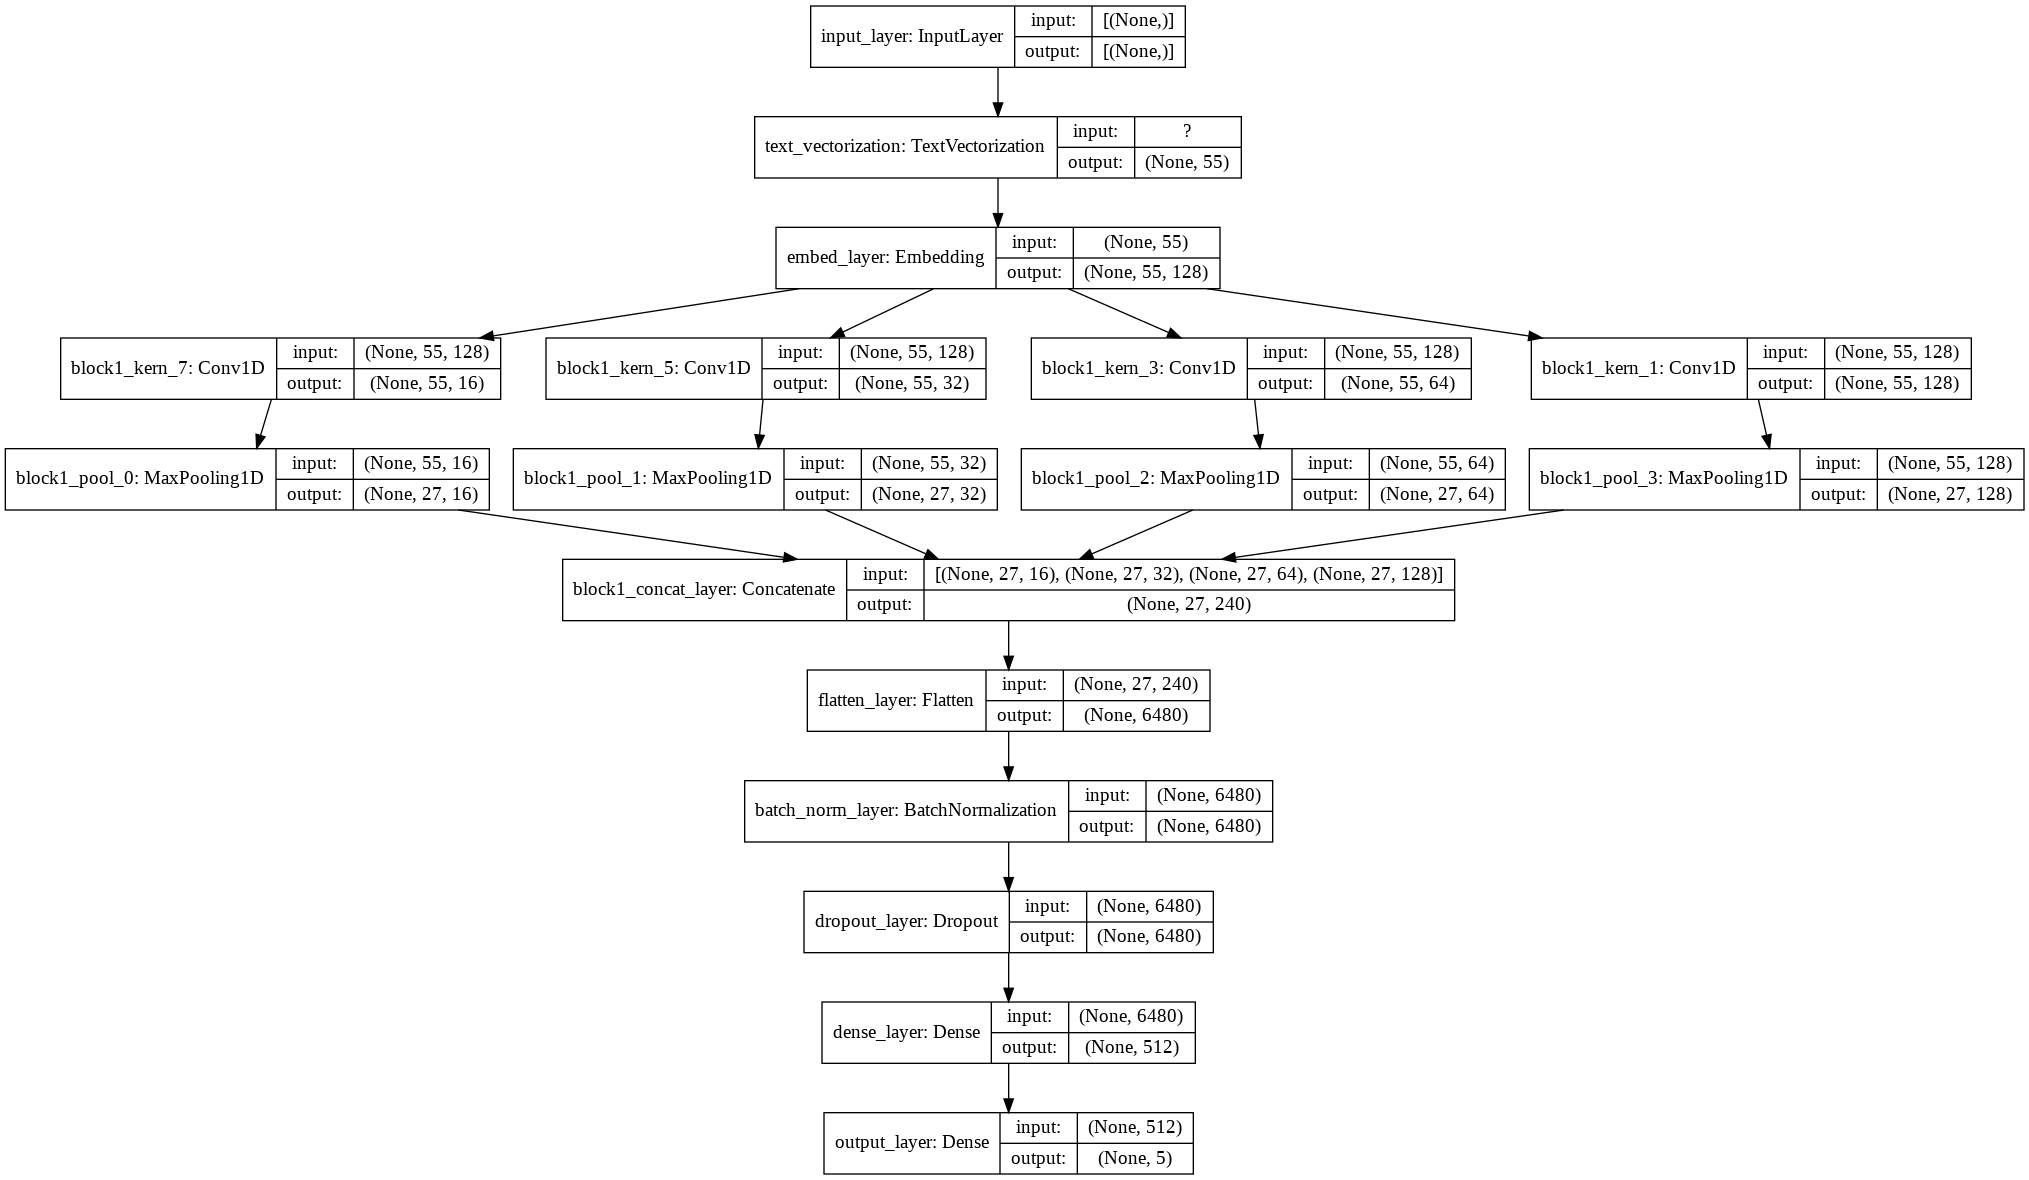

In [40]:
tf.keras.utils.plot_model(model7, show_shapes=True)

In [43]:
train_df['target'] = oe.fit_transform(train_df.target.values.reshape(-1, 1))
valid_df['target'] = oe.transform(valid_df.target.values.reshape(-1, 1))
test_df['target'] = oe.transform(test_df.target.values.reshape(-1, 1))


train_df_one_hot = tf.keras.utils.to_categorical(train_df.target.values, 5)
valid_df_one_hot = tf.keras.utils.to_categorical(valid_df.target.values, 5)
test_df_one_hot = tf.keras.utils.to_categorical(test_df.target.values, 5)

train_dataset = tf.data.Dataset.from_tensor_slices((train_df.text.values, train_df_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_df.text.values, valid_df_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_df.text.values, test_df_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset, valid_dataset

(<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float32)>,
 <PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float32)>)

In [49]:
# defining the epoch steps 
TRAIN_STEPS = int(0.001 * train_df.shape[0])
VALID_STEPS = int(0.01 * valid_df.shape[0])
TRAIN_STEPS, VALID_STEPS

(2211, 1446)

In [51]:
model_7_hist = model7.fit(train_dataset,
                           epochs=EPOCHS,
                           verbose=1,
                           steps_per_epoch=TRAIN_STEPS,
                           validation_data=valid_dataset,
                           validation_steps=VALID_STEPS
                         )

Epoch 1/5
2211/2211 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.7604WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1446 batches). You may need to use the repeat() function when building your dataset.


2211/2211 [==============================] - 409s 185ms/step - loss: 0.6513 - accuracy: 0.7604 - val_loss: 0.5458 - val_accuracy: 0.7993
Epoch 2/5
2211/2211 [==============================] - 381s 173ms/step - loss: 0.5654 - accuracy: 0.7931
Epoch 3/5
2211/2211 [==============================] - 379s 172ms/step - loss: 0.5672 - accuracy: 0.7926
Epoch 4/5
2211/2211 [==============================] - 384s 174ms/step - loss: 0.5259 - accuracy: 0.8087
Epoch 5/5
2211/2211 [==============================] - 384s 174ms/step - loss: 0.5282 - accuracy: 0.8087


In [52]:
model7.evaluate(valid_dataset)

905/905 [==============================] - 16s 18ms/step - loss: 0.4670 - accuracy: 0.8310


[0.46699485182762146, 0.8310175538063049]

### Model1 with LSTM layer

In [55]:
inputs = tf.keras.Input(shape=[], dtype=tf.string, name='input_layer')
x = text_vec_small(inputs)
x = emb_layer(x)
x = tf.keras.layers.Dropout(0.4, name='dropout_layer1')(x)
# calling the block function
concat = block(inputs=x,
               kernel_sizes=KERNELS,
               num_filters=FILTERS,
               padding=PADDING,
               activation='relu',
               block_name='block1')
print(concat.shape)
# x = tf.keras.layers.Flatten(name='flatten_layer')(concat)
x = tf.keras.layers.BatchNormalization(name='batch_norm_layer')(concat)
x = tf.keras.layers.Dropout(0.3, name='dropout_layer2')(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),
                                 name='bidirect_lstm_layer')(x)

print(x.shape)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

model8 = tf.keras.Model(inputs, outputs, name='model_use_blocks_lstm')

model8.compile(optimizer=tf.keras.optimizers.Adam(0.0001), 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
model8.summary()

(None, 27, 240)
(None, 128)
Model: "model_use_blocks_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 55)           0           input_layer[0][0]                
__________________________________________________________________________________________________
embed_layer (Embedding)         (None, 55, 128)      8299648     text_vectorization[5][0]         
__________________________________________________________________________________________________
dropout_layer1 (Dropout)        (None, 55, 128)      0           embed_layer[5][0]                
__________________________________________________

In [56]:
model_8_hist = model8.fit(train_dataset,
                           epochs=EPOCHS,
                           verbose=1,
                           steps_per_epoch=1500,
                           validation_data=valid_dataset,
                           validation_steps=400
                         )

Epoch 1/5
1500/1500 [==============================] - 290s 191ms/step - loss: 0.6710 - accuracy: 0.7559 - val_loss: 0.5234 - val_accuracy: 0.8116
Epoch 2/5
1500/1500 [==============================] - 288s 192ms/step - loss: 0.5298 - accuracy: 0.8062 - val_loss: 0.5044 - val_accuracy: 0.8158
Epoch 3/5
1500/1500 [==============================] - 289s 192ms/step - loss: 0.5102 - accuracy: 0.8131 - val_loss: 0.4877 - val_accuracy: 0.8230
Epoch 4/5
1500/1500 [==============================] - 288s 192ms/step - loss: 0.5155 - accuracy: 0.8110 - val_loss: 0.4756 - val_accuracy: 0.8273
Epoch 5/5
1500/1500 [==============================] - 290s 193ms/step - loss: 0.5004 - accuracy: 0.8170 - val_loss: 0.4699 - val_accuracy: 0.8313


905/905 [==============================] - 21s 24ms/step - loss: 0.4690 - accuracy: 0.8300
[0.46897754073143005, 0.8300151824951172]


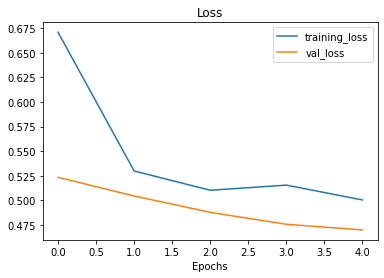

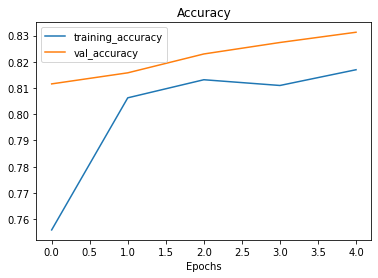

In [57]:
print(model8.evaluate(valid_dataset))
plot_loss_curves(model_8_hist)

In [58]:
# model8.evaluate(test_dataset)
y_pred_model_8 = model8.predict(test_dataset)
model_results(y_true=test_df_one_hot.argmax(axis=1),
              y_pred=y_pred_model_8.argmax(axis=1))

The Accuracy is:  0.8258

The Precsion is:  0.8233

The F1 is:  0.8235


### Model2: char and sentence input with LSTM layer

In [60]:
# making the characters
train_chars = character_making(train_df.text.values)
valid_chars = character_making(valid_df.text.values)

# defining the datasets
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_df.text.values, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_df_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((valid_df.text.values, valid_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(valid_df_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float32)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float32)>)

In [62]:
# defining the global variables

KERNELS1 = [7, 5, 3, 1]
KERNELS2 = [15, 13, 7, 5]
FILTERS = [32, 32, 128, 64]

PADDING = 'causal'
ACTIVATION = 'relu'

# creating the model

inputs1 = tf.keras.Input(shape=[], dtype=tf.string, name='input_sent_layer')
inputs2 = tf.keras.Input(shape=[], dtype=tf.string, name='input_char_layer')

# Text vectorizer of sentences and embedding
x1 = text_vec_small(inputs1)
x1 = emb_layer(x1)
x1 = tf.keras.layers.Dropout(0.3, name='dropout_sent_layer')(x1)
# Text vectorizer of characters and embedding
x2 = char_vectorizer(inputs2)
x2 = embed_char_layer(x2)
x2 = tf.keras.layers.Dropout(0.3, name='dropout_char_layer')(x2)
# The block of sentences' embeddings
concat1 = block(inputs=x1,
               kernel_sizes=KERNELS1,
               num_filters=FILTERS,
               padding=PADDING,
               activation='relu',
               block_name='block_sent')

# The block of characters' embeddings
concat2 = block(inputs=x2,
               kernel_sizes=KERNELS2,
               num_filters=FILTERS,
               padding=PADDING,
               activation='relu',
               block_name='block_char')

# Concating 2 blocks by 1 axis
concat = tf.keras.layers.concatenate([concat1, concat2], axis=1)
# x = tf.keras.layers.Flatten(name='flatten_layer')(concat)
x = tf.keras.layers.BatchNormalization(name='batch_norm_layer')(concat)
x = tf.keras.layers.Dropout(0.5, name='dropout_layer')(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),
                                 name='bidirect_lstm_layer')(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

model10 = tf.keras.Model([inputs1, inputs2], outputs, name='char_sent_blocks')

model10.compile(optimizer=tf.keras.optimizers.Adam(0.0001), 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
model10.summary()

Model: "char_sent_blocks"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sent_layer (InputLayer)   [(None,)]            0                                            
__________________________________________________________________________________________________
input_char_layer (InputLayer)   [(None,)]            0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 55)           0           input_sent_layer[0][0]           
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 300)          0           input_char_layer[0][0]           
___________________________________________________________________________________

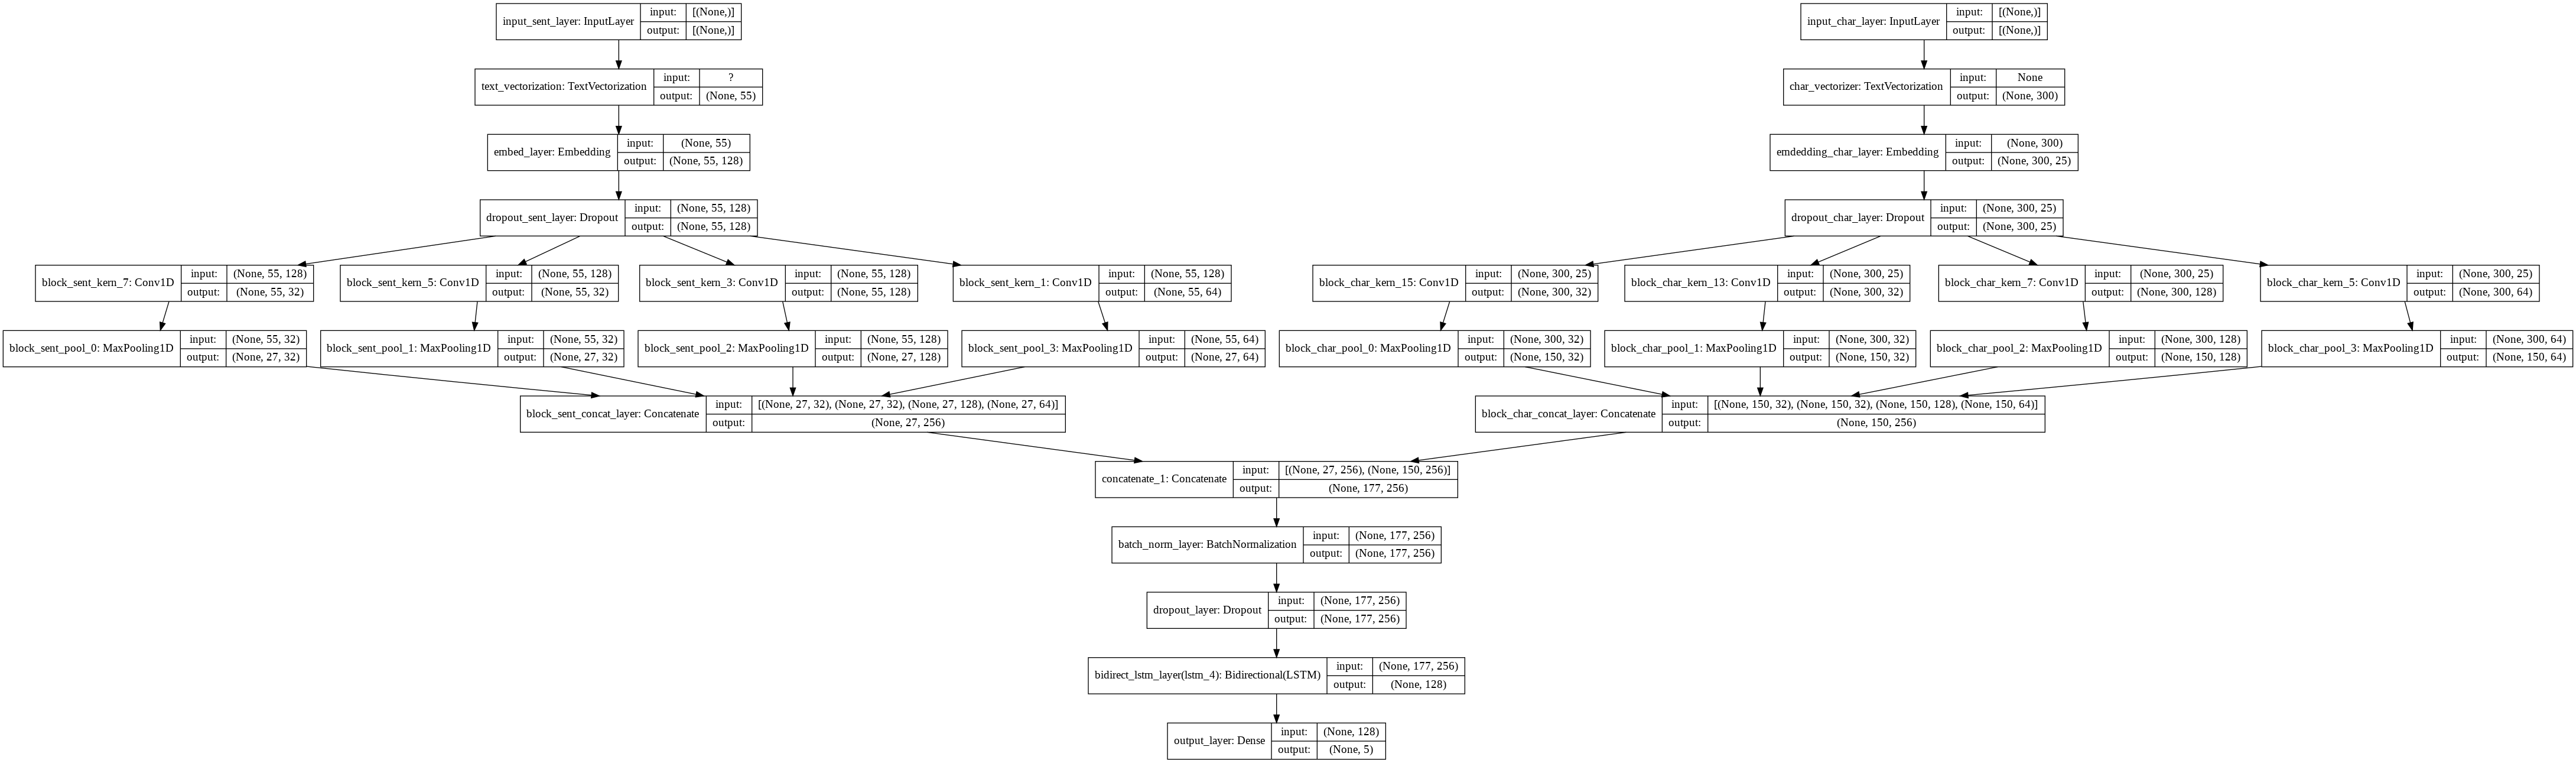

In [63]:
tf.keras.utils.plot_model(model10, show_shapes=True)

In [ ]:
model_10_hist = model10.fit(train_char_token_dataset,
                           epochs=EPOCHS,
                           verbose=1,
                           steps_per_epoch=1500,
                           validation_data=val_char_token_dataset,
                           validation_steps=400
                         )

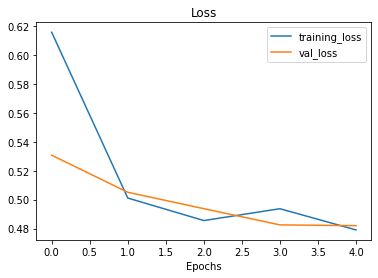

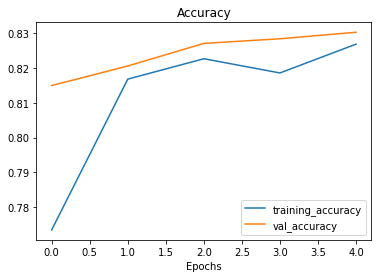

In [66]:
plot_loss_curves(model_10_hist)

In [68]:
y_pred_model_10 = model10.predict(val_char_token_dataset)
model_results(y_true=valid_df_one_hot.argmax(axis=1),
              y_pred=y_pred_model_10.argmax(axis=1))

The Accuracy is:  0.8289

The Precsion is:  0.8267

The F1 is:  0.8266


# Hybrid Model from paper
This model has 3 inputs 
1. Characters
2. Sentences
3. The corresponding number of sentence in paper(one_hot)

### Block 1:
* Character Vectorizer
* Embedding
* Bidirectional LSTM

### Block 2:
* Sentence Vectorizer
* Embedding 

### Block 3:
* Dense layer
* Expanding last axis

### Concating 3 block
* LSTM
* Softmax

In [74]:
train_df.line.to_numpy()

array([ 1,  2,  3, ...,  8,  9, 10])

In [78]:
# creating new feature
train_line_one_hot = tf.keras.utils.to_categorical(train_df.line.to_numpy(), 52)
valid_line_one_hot = tf.keras.utils.to_categorical(valid_df.line.values, 52)

# creating new datasets 

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_df.text.values, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_df_one_hot) # make labels
train_char_token_lines = tf.data.Dataset.from_tensor_slices(train_line_one_hot) # combine data and labels
train_char_token_lines_data = tf.data.Dataset.zip((train_char_token_data, train_char_token_lines))
train_char_token_lines_dataset = tf.data.Dataset.zip((train_char_token_lines_data, train_char_token_labels))
train_char_token_lines_dataset = train_char_token_lines_dataset.batch(64).prefetch(tf.data.AUTOTUNE)


# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((valid_df.text.values, valid_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(valid_df_one_hot) # make labels
val_char_token_lines = tf.data.Dataset.from_tensor_slices(valid_line_one_hot) # combine data and labels
val_char_token_lines_data = tf.data.Dataset.zip((val_char_token_data, val_char_token_lines))
val_char_token_lines_dataset = tf.data.Dataset.zip((val_char_token_lines_data, val_char_token_labels))
val_char_token_lines_dataset = val_char_token_lines_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

train_char_token_lines_dataset, val_char_token_lines_dataset

(<PrefetchDataset shapes: ((((None,), (None,)), (None, 52)), (None, 5)), types: (((tf.string, tf.string), tf.float32), tf.float32)>,
 <PrefetchDataset shapes: ((((None,), (None,)), (None, 52)), (None, 5)), types: (((tf.string, tf.string), tf.float32), tf.float32)>)

In [83]:
len(train_char_token_lines_dataset), len(val_char_token_lines_dataset)

(34561, 453)

In [96]:
# Creating the model

# Block 1 

inputs1 = tf.keras.Input(shape=[], batch_size=64,
                         dtype=tf.string, name='token_input')
token_vec = text_vec_small(inputs1)
token_emb = emb_layer(token_vec)

outputs1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64), 
                                        name='token_bidirect_layer')(token_emb)
print(outputs1.shape)


# Block 2
inputs2 = tf.keras.Input(shape=[], batch_size=64, 
                         dtype=tf.string, name='char_input')
char_vec =  char_vectorizer(inputs2)

char_emb = embed_char_layer(char_vec)
outputs2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64), 
                                        name='char_bidirect_layer')(char_emb)
print(outputs2.shape)




# Block 3
inputs3 = tf.keras.Input(shape=(52, ), name='line_input')
outputs3 = tf.keras.layers.Dense(256, activation='relu', name='line_dense_layer')(inputs3)
print(x.shape)


# Concatenating
concat_layer = tf.keras.layers.Concatenate(name='concat')([outputs1,
                                                           outputs2,
                                                           outputs3])
print(concat_layer.shape)
# Combined Dropout layer 
comb_drop = tf.keras.layers.Dropout(0.5)(concat_layer)

# Combined dense layer
x = tf.keras.layers.Dense(256, name='comb_dense_layer')(comb_drop)

# Dropout before last layer
final_drop = tf.keras.layers.Dropout(0.5)(x)

# Output
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output')(final_drop)

model11 = tf.keras.Model(inputs=[inputs1, inputs2, inputs3],
                         outputs=outputs,
                         name='hybrid_token_char_model')


(None, 128)
(None, 128)
(None, 256)
(None, 512)


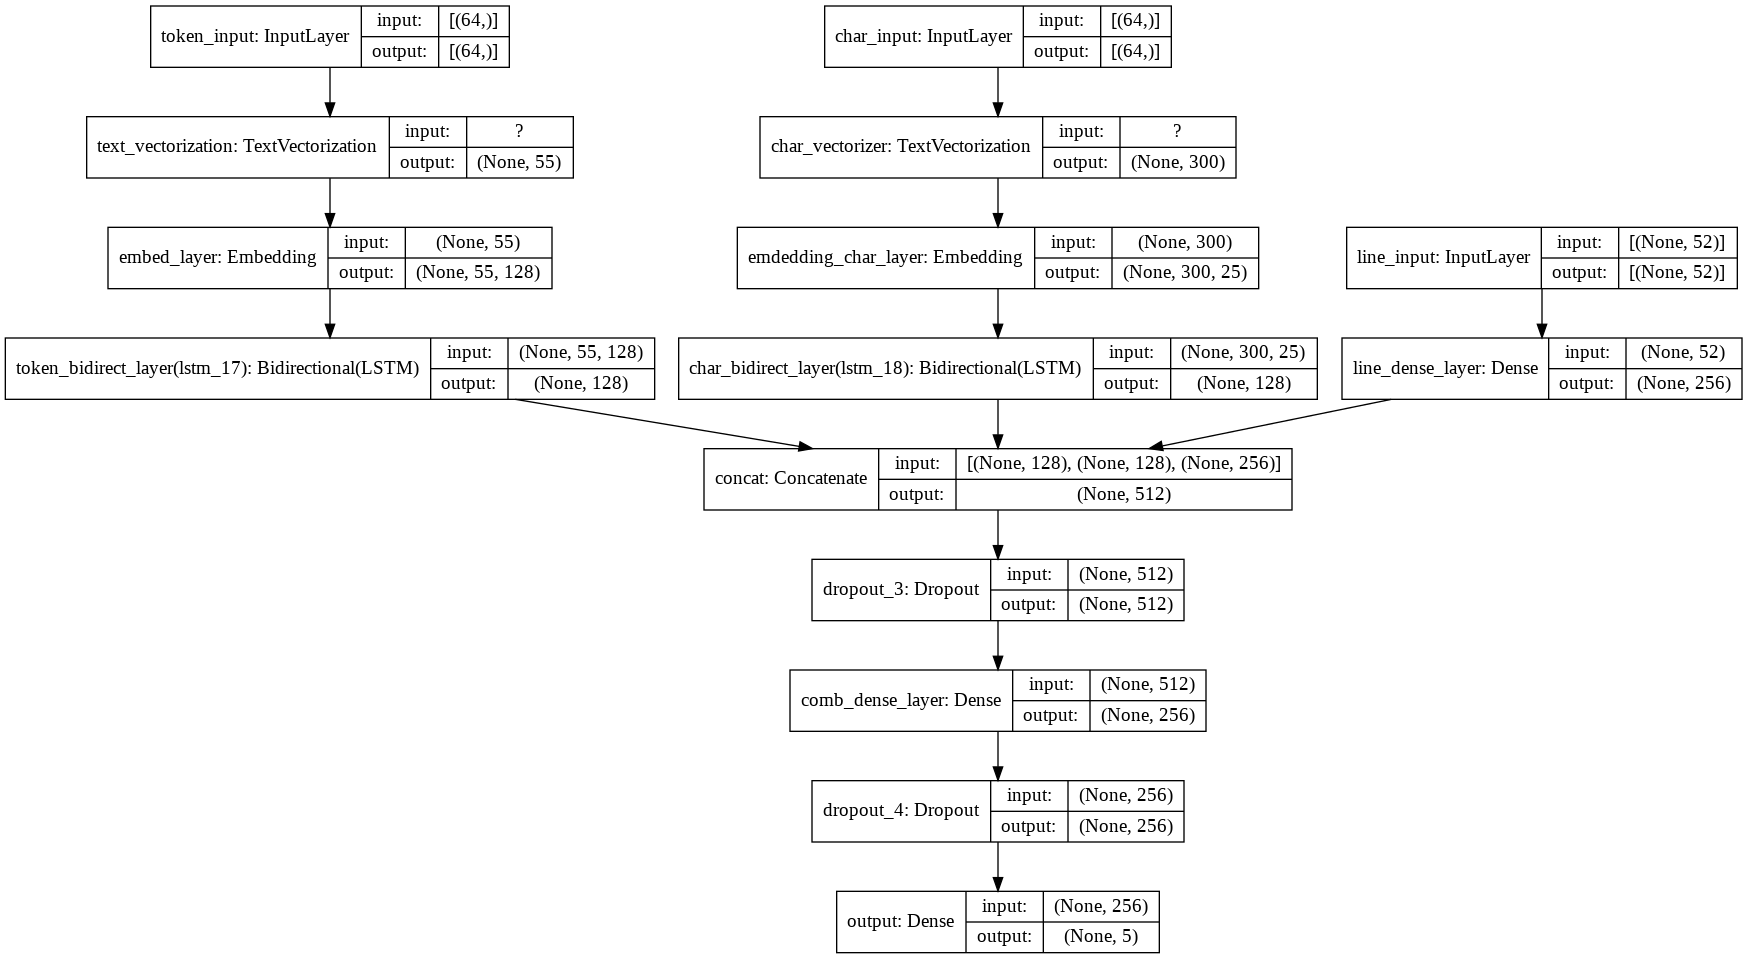

In [97]:
model11.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

tf.keras.utils.plot_model(model11, show_shapes=True)

In [98]:
model_11_history = model11.fit(train_char_token_lines_dataset, # train on dataset of token and characters
                              steps_per_epoch=1500,
                              epochs=5,
                              validation_data=val_char_token_lines_dataset,
                              validation_steps=250
                               )

Epoch 1/5
1500/1500 [==============================] - 1340s 868ms/step - loss: 0.4273 - accuracy: 0.8398 - val_loss: 0.3763 - val_accuracy: 0.8566
Epoch 2/5
1500/1500 [==============================] - 1314s 876ms/step - loss: 0.3878 - accuracy: 0.8532 - val_loss: 0.3551 - val_accuracy: 0.8676
Epoch 3/5
1500/1500 [==============================] - 1312s 875ms/step - loss: 0.3729 - accuracy: 0.8613 - val_loss: 0.3493 - val_accuracy: 0.8676
Epoch 4/5
1500/1500 [==============================] - 1309s 873ms/step - loss: 0.3704 - accuracy: 0.8604 - val_loss: 0.3405 - val_accuracy: 0.8694
Epoch 5/5
1500/1500 [==============================] - 1305s 870ms/step - loss: 0.3673 - accuracy: 0.8657 - val_loss: 0.3246 - val_accuracy: 0.8787


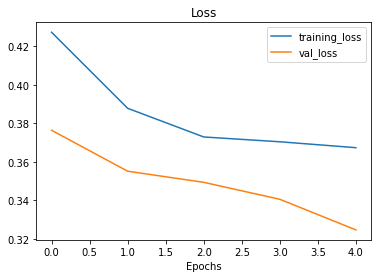

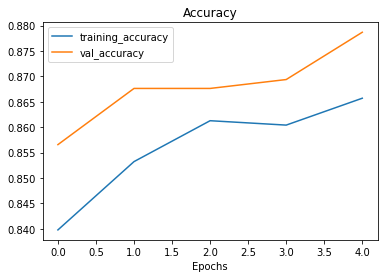

In [99]:
plot_loss_curves(model_11_history)

In [101]:
y_pred_model_11 = model11.predict(val_char_token_lines_dataset)
model_results(y_true=valid_df_one_hot.argmax(axis=1),
              y_pred=y_pred_model_11.argmax(axis=1))

The Accuracy is:  0.8779

The Precsion is:  0.8777

The F1 is:  0.8769


# View results and Error analysis

In [103]:
from sklearn.metrics import confusion_matrix
confusion_matrix(valid_df_one_hot.argmax(axis=1),
                 y_pred_model_11.argmax(axis=1))

array([[2004,   54,  123,  382,   12],
       [  35, 3813,   42,    0,  506],
       [  55,   35, 9040,   36,  393],
       [ 706,    1,  125, 1586,    7],
       [   7,  339,  675,    1, 8955]])

In [116]:
classes = list(oe.categories_[0])

In [110]:
import itertools
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

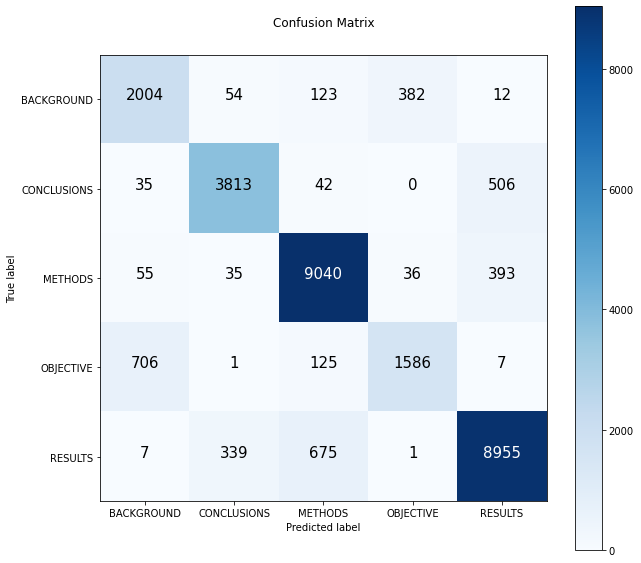

In [111]:
make_confusion_matrix(y_true=valid_df_one_hot.argmax(axis=1),
                      y_pred=y_pred_model_11.argmax(axis=1),
                      classes=list(oe.categories_[0]))

In [128]:
results = pd.DataFrame(data={"Actual": valid_df_one_hot.argmax(axis=1),
                      "Predicted": y_pred_model_11.argmax(axis=1)})
true_label = []
pred_label = []
true_prob = []
pred_prob = []
for i in range(results.shape[0]):
  true_label.append(classes[results.Actual.values[i]])
  pred_label.append(classes[results.Predicted.values[i]])
  true_prob.append(y_pred_model_11[i][results.Actual.values[i]])
  pred_prob.append(y_pred_model_11[i][results.Predicted.values[i]])
results['Actual_class'] = true_label
results['Actual_prob'] = true_prob
results['Pred_class'] = pred_label
results['Pred_prob'] = pred_prob
results['text'] = valid_df.text.values
results.head(10)

,Actual,Predicted,Actual_class,Actual_prob,Pred_class,Pred_prob,text
0,0,0,BACKGROUND,0.706499,BACKGROUND,0.706499,Adrenergic activation is thought to be an impo...
1,4,2,RESULTS,0.013484,METHODS,0.889757,Systemic venous norepinephrine was measured at...
2,4,4,RESULTS,0.825760,RESULTS,0.825760,Baseline norepinephrine level was associated w...
3,4,4,RESULTS,0.958827,RESULTS,0.958827,"On multivariate analysis , baseline norepineph..."
4,4,2,RESULTS,0.359526,METHODS,0.594253,"In contrast , the relation of the change in no..."
5,4,4,RESULTS,0.978415,RESULTS,0.978415,In the placebo-treated group but not in the bu...
6,4,4,RESULTS,0.958791,RESULTS,0.958791,In the bucindolol-treated group but not in the...
7,4,4,RESULTS,0.953041,RESULTS,0.953041,A likelihood-based method indicated that @ % o...
8,1,1,CONCLUSIONS,0.658300,CONCLUSIONS,0.658300,"In BEST , a subset of patients treated with bu..."
9,3,3,OBJECTIVE,0.755029,OBJECTIVE,0.755029,The study evaluated the effectiveness of a thr...


In [129]:
errors = results.loc[results.Actual != results.Predicted]
errors['pred_diff'] = errors['Pred_prob'] - errors['Actual_prob']
errors = errors.sort_values(by="pred_diff", ascending=False)
errors.head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Actual,Predicted,Actual_class,Actual_prob,Pred_class,Pred_prob,text,pred_diff
20424,2,4,METHODS,0.000220,RESULTS,0.999334,Diastolic BP decreased more in orlistat-treate...,0.999114
20426,2,4,METHODS,0.000163,RESULTS,0.998709,The orlistat-treated group had significantly g...,0.998546
27392,3,2,OBJECTIVE,0.000903,METHODS,0.997370,Twelve healthy male volunteers received on thr...,0.996467
26351,2,4,METHODS,0.001321,RESULTS,0.997315,Although the rate of AmB nephrotoxicity was hi...,0.995994
27393,3,2,OBJECTIVE,0.001194,METHODS,0.996497,A wash-out period of at least @ days elapsed b...,0.995303
17180,2,4,METHODS,0.002542,RESULTS,0.997215,"The mean size , depth of infiltrate and LogMAR...",0.994672
2859,4,2,RESULTS,0.002441,METHODS,0.997025,Healthy subjects ( n = @ ) were randomized usi...,0.994584
12764,0,2,BACKGROUND,0.001357,METHODS,0.995880,Outcome is measured at six months via a postal...,0.994523
16154,4,2,RESULTS,0.002485,METHODS,0.997007,"Cross-sectional areas of the vessel , lumen , ...",0.994522
10239,1,4,CONCLUSIONS,0.002396,RESULTS,0.996696,Testosterone increased from castrate to median...,0.994300


In [134]:
errors.iloc[794, :]

Actual                                                          3
Predicted                                                       2
Actual_class                                            OBJECTIVE
Actual_prob                                             0.0889465
Pred_class                                                METHODS
Pred_prob                                                0.788627
text            Data from the Childhood Asthma Management Prog...
pred_diff                                                0.699681
Name: 2119, dtype: object

In [144]:
for i in range(3):
  error_indexes = list(errors.index)
  example_index = np.random.choice(error_indexes)
  example = errors.filter(items=[example_index], axis=0)

  print(f"The wrong predicted sentence: \n {example['text'].values[0]} \n")

  print(f"The Actual label and its predicted probability: \n {example['Actual_class'].values[0], example['Actual_prob'].values[0]} \n")

  print(f"The Predicted label and its predicted probability: \n {example['Pred_class'].values[0], example['Pred_prob'].values[0]} \n")

  print("*" * 50)

The wrong predicted sentence: 
 So far , however , there were no data on glycemic control by postprandial aspart insulin in patients with type @ diabetes .
 

The Actual label and its predicted probability: 
 ('OBJECTIVE', 0.16637912392616272) 

The Predicted label and its predicted probability: 
 ('BACKGROUND', 0.498649924993515) 

**************************************************
The wrong predicted sentence: 
 We developed a study aiming to evaluate whether or not a limit of age could be identified beyond which toxicities in patients receiving pelvic RT were more frequent or more severe .
 

The Actual label and its predicted probability: 
 ('OBJECTIVE', 0.42830929160118103) 

The Predicted label and its predicted probability: 
 ('BACKGROUND', 0.5398011207580566) 

**************************************************
The wrong predicted sentence: 
 The effects of treatment with ethinyloestradiol ( EE@ ) or oxandrolone ( OX ) on parameters of gonadotrophin secretion were also evaluate

Next notebook same models will be trained with more and different data preprocessing steps